In [1]:
import numpy as np
from matplotlib import pyplot as plt

# PART A. Distance-Based (k-means)

## 1:

In [2]:
def k_means(x, k, tol = 1e-5):

    # picking k cluster centers:
    centers = x[np.random.choice(x.shape[0], k, replace=False), :]
    centers = centers.reshape(k, 1, -1) # to replace for with arraywise operation, we should add an extra dimension
    # preallocating error
    error = 1
    while error > tol:
        new_centers = np.empty_like(centers) # new_centers to check with previous ones 
        distance = np.sum((x[np.newaxis, :, :] - centers) ** 2, 2) # calculating distance of each sample with each cluster
        result = np.argmin(distance, 0) # clustering
        for i in range(k):
            new_centers[i] = x[result == i].mean(0) # making new centers
        error = np.sum(((new_centers - centers)/new_centers) ** 2)
        centers = new_centers.copy()
    cost = 0
    for i in range(k):
        cost += np.sum((x[result == i] - centers[i]) ** 2, None)
    return result, centers, cost


# 2, 3:

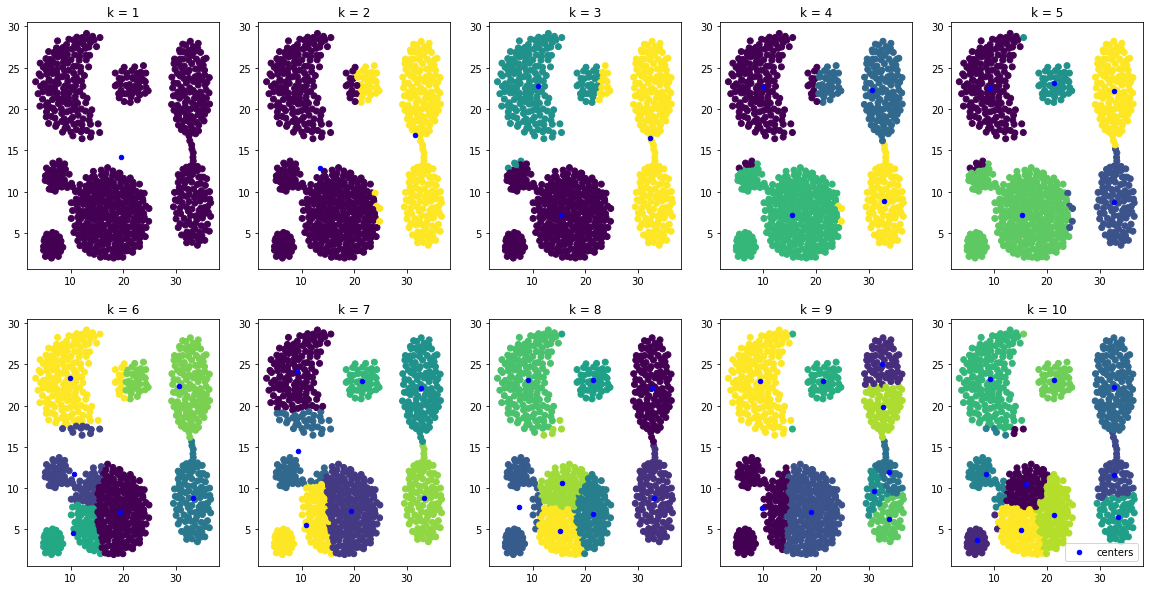

In [3]:
x = np.loadtxt('Aggregation.txt') # loading data
y = x[:, -1]
x = x[:, :-1]
fig, axs = plt.subplots(2, 5, figsize = (20, 10))
axs = axs.flatten()
costs = np.zeros(10, 'float')
for i in range(1, 11):
    clusters, centers, costs[i-1] = k_means(x, i, 0)
    axs[i-1].set_title(f'k = {i}')
    axs[i-1].scatter(*x.T, c = clusters)
    axs[i-1].scatter(*centers.reshape(i, -1).T, c = 'blue', s = 20, label = 'centers')
plt.legend();

## 4

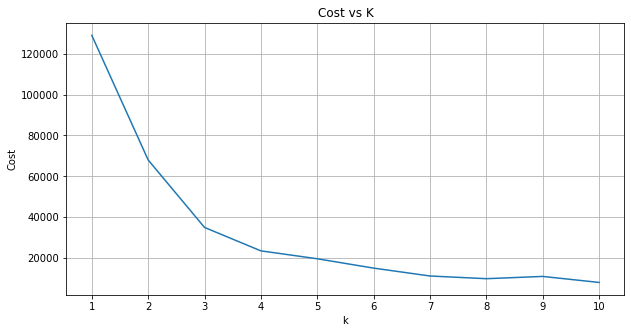

In [4]:
plt.figure(figsize = (10, 5))
plt.plot(np.arange(1, 11), costs);
plt.xticks(np.arange(1, 11), np.arange(1, 11))
plt.ylabel('Cost')
plt.xlabel('k')
plt.title('Cost vs K')
plt.grid()

## 5: 
Due to elbow rule, the best k for this example is 2 or 3

## 6:

what does accuracy for a clustering method even mean?

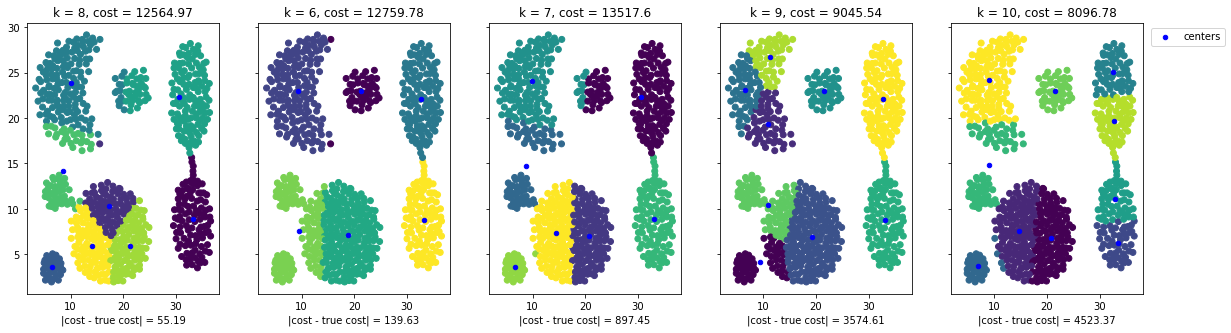

In [5]:
fig, axs = plt.subplots(1, 5, figsize = (20, 5), sharey=True)
axs = axs.flatten()
costs = np.zeros(10, 'float')
cluster = {}
for i in range(1, 11):
    clusters, centers, costs[i-1] = k_means(x, i, 0)
    cluster.update({i : {'clusters': clusters, 'centers': centers, 'cost': costs[i-1]}})


labels = np.unique(y)
true_cost = 0
for i in np.unique(y):
    true_center = x[y == i, :].mean(0)
    true_cost += np.sum((x[y == i, :] - true_center) ** 2, None)

id = np.argsort(np.abs(costs-true_cost)) # -> k - 1
for i in range(len(axs)):
    clusters, centers = cluster[id[i]+1]['clusters'], cluster[id[i]+1]['centers']
    axs[i].set_title(f'k = {id[i]+1}, cost = {costs[id[i]].round(2)}')
    axs[i].scatter(*x.T, c = clusters)
    axs[i].scatter(*centers.reshape(id[i]+1, -1).T, c = 'blue', s = 20, label = 'centers')
    axs[i].set_xlabel(f'|cost - true cost| = {abs(costs[id[i]] - true_cost):.2f}')
plt.legend(bbox_to_anchor=(1.45, 1));

# PART B. Density-Based (DBSCAN)

In [6]:
from sklearn.cluster import DBSCAN

## 1

In [7]:
x = np.loadtxt('Aggregation.txt') # loading data
y = x[:, -1]
x = x[:, :-1]
minPts = np.array([5, 8, 12, 14, 15, 16, 20, 30, 50, 60])
eps = np.array([.1, .3, 0.5, .8, 1, 1.7, 2, 2.5, 3, 4])
MinPts, Eps = np.meshgrid(minPts, eps)

In [8]:
eps.shape

(10,)

## 2

In [9]:
def mse(x, y):
    return np.sum((x - y) ** 2, None)/x.shape[0]

In [10]:
from sklearn.metrics.cluster import v_measure_score

In [11]:
db = np.zeros_like(MinPts, dtype=DBSCAN)
mse_result = np.zeros_like(MinPts, 'float')
vmes_result = np.zeros_like(MinPts, 'float')
for i in range(MinPts.shape[0]):
    for j in range(MinPts.shape[1]):
        db[i, j] = DBSCAN(eps=Eps[i, j], min_samples=MinPts[i, j]).fit(x)
        mse_result[i, j] = mse(y, db[i, j].labels_)
        vmes_result[i, j] = v_measure_score(y, db[i, j].labels_)

## 3

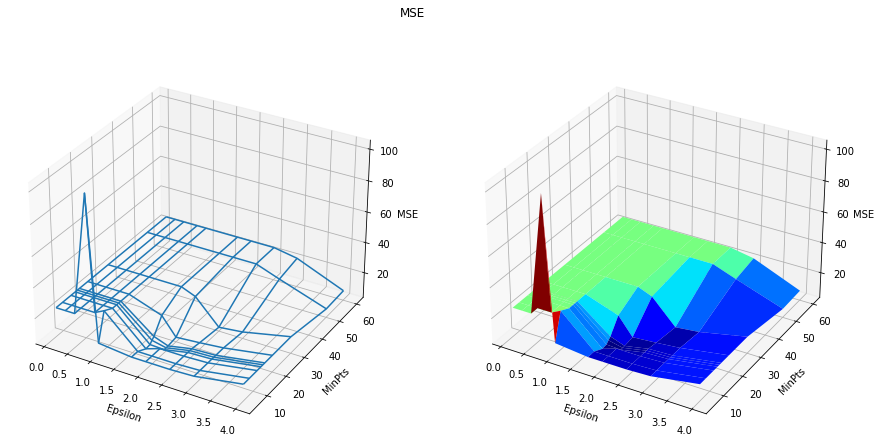

In [12]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(Eps, MinPts, mse_result, cmap='jet')
ax.set_xlabel('Epsilon')
ax.set_ylabel('MinPts')
ax.set_zlabel('MSE')
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(Eps, MinPts, mse_result, cmap='jet')
ax.set_xlabel('Epsilon')
ax.set_ylabel('MinPts')
ax.set_zlabel('MSE')
plt.suptitle('MSE')
plt.show()


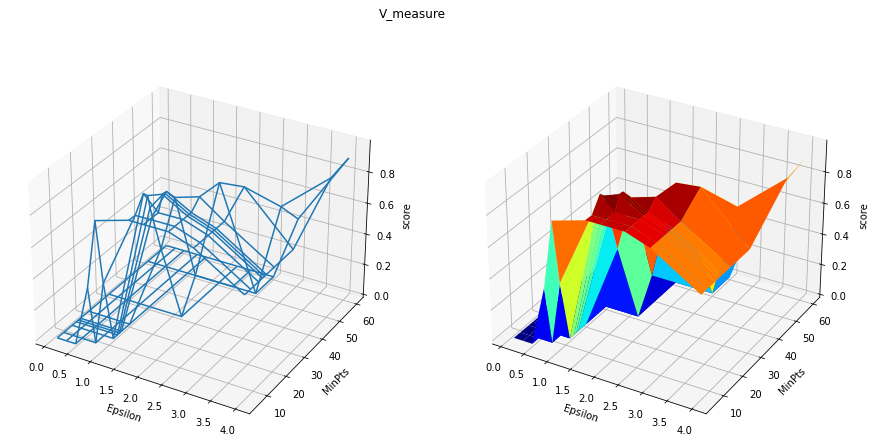

In [13]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(Eps, MinPts, vmes_result, cmap='jet')
ax.set_xlabel('Epsilon')
ax.set_ylabel('MinPts')
ax.set_zlabel('score')
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(Eps, MinPts, vmes_result, cmap='jet')
ax.set_xlabel('Epsilon')
ax.set_ylabel('MinPts')
ax.set_zlabel('score')
plt.suptitle('V_measure')
plt.show()


## 4:

Text(0.5, 1.0, 'Ground Truth')

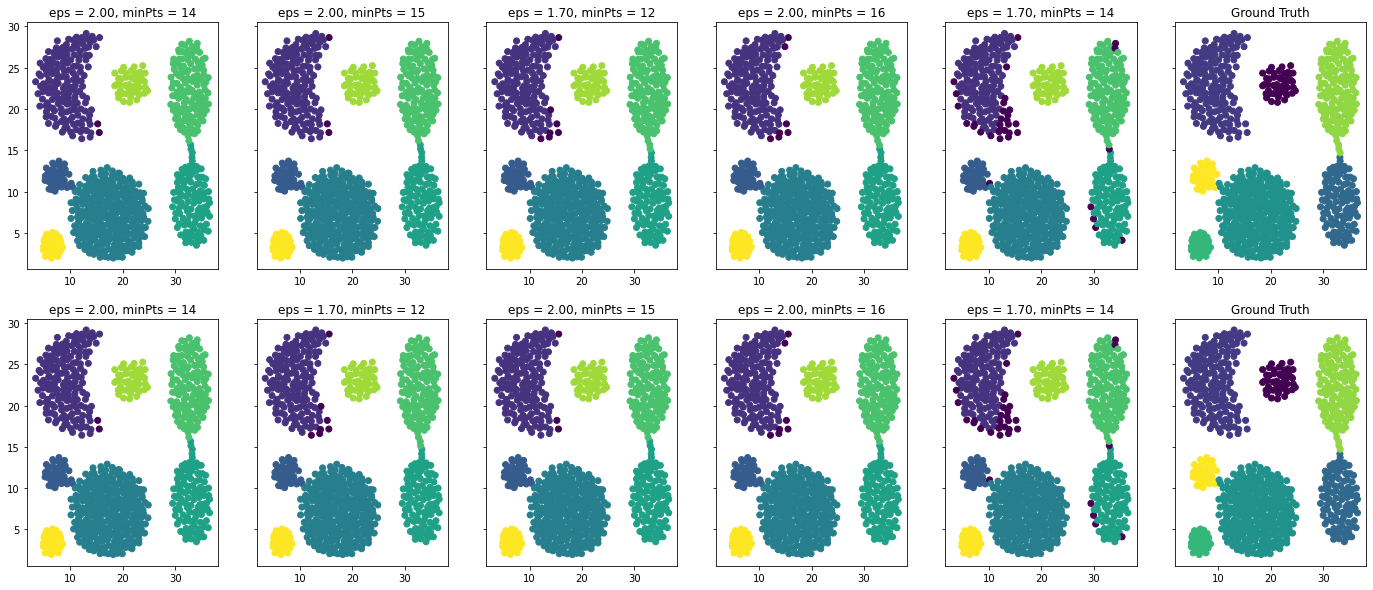

In [14]:
fig, axs = plt.subplots(2, 6, figsize = (24, 10), sharey=True)
axs = axs.flatten()

id = np.argsort(mse_result, None)
id2 = np.argsort(vmes_result, None)
id2 = id2[::-1]
for i in range(5):
    temp_db = db.item(id[i])
    axs[i].set_title(f'eps = {temp_db.eps:.2f}, minPts = {temp_db.min_samples}')
    axs[i].scatter(*x.T, c = temp_db.labels_)
axs[5].scatter(*x.T, c = y)
axs[5].set_title(f'Ground Truth')

for i in range(6, 11):
    temp_db = db.item(id2[i-6])
    axs[i].set_title(f'eps = {temp_db.eps:.2f}, minPts = {temp_db.min_samples}')
    axs[i].scatter(*x.T, c = temp_db.labels_)
axs[-1].scatter(*x.T, c = y)
axs[-1].set_title(f'Ground Truth')

## 5:
<div dir = 'rtl'>
چونکه شکل کلاستر‌های ما دایره یا کروی یا ... نیست، میتوان گفت که DBScan بهتر عمل میکند.
<br>این شکل ها نیز این قضیه را ثابت میکند
</div>

# PART C. Kmeans and DBSCAN and Agglomerative Clustering

## 1:

In [15]:
from sklearn.datasets import make_blobs, make_circles, make_moons
X1, y1 = make_circles(n_samples=1000, shuffle=True, noise=0.2, random_state=0,factor=0.8)
X2, y2 = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=0)
X3, y3 = make_blobs(n_samples=1000, n_features=2, cluster_std=1.0, shuffle=True, random_state=0)
X4, y4 = np.random.rand(1000, 2), np.random.randint(0,3,(1000,1))

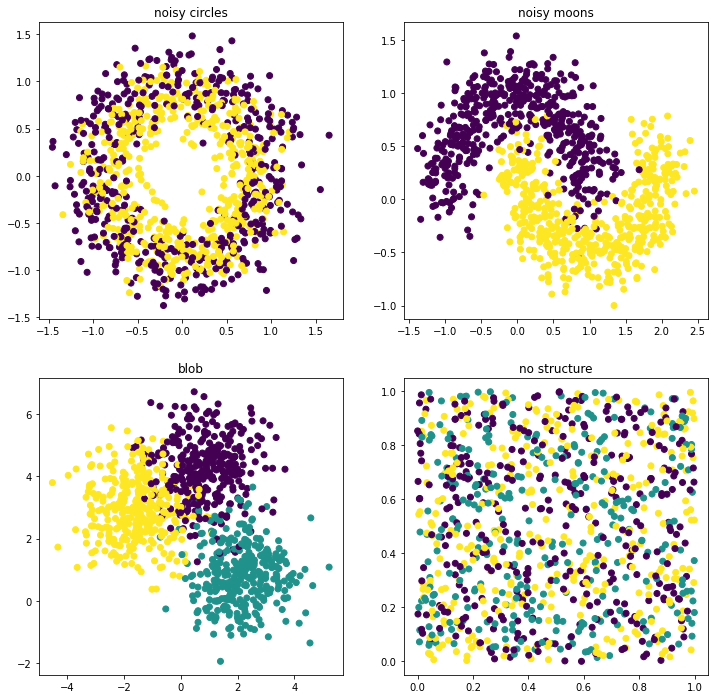

In [16]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('noisy circles')
plt.scatter(*X1.T, c = y1)
plt.subplot(222)
plt.title('noisy moons')
plt.scatter(*X2.T, c = y2)
plt.subplot(223)
plt.title('blob')
plt.scatter(*X3.T, c = y3)
plt.subplot(224)
plt.title('no structure')
plt.scatter(*X4.T, c = y4);

## 2:

### K-means

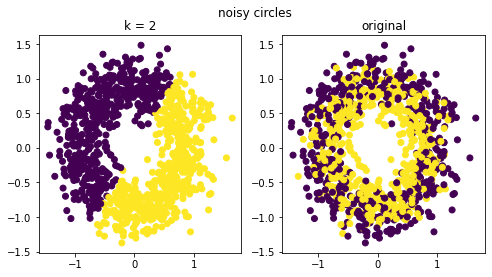

In [17]:
clusters, centers, costs = k_means(X1, 2, 1e-5)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X1.T, c = clusters)
plt.title(f'k = 2')
plt.subplot(122)
plt.title('original')
plt.scatter(*X1.T, c = y1)

plt.suptitle('noisy circles');

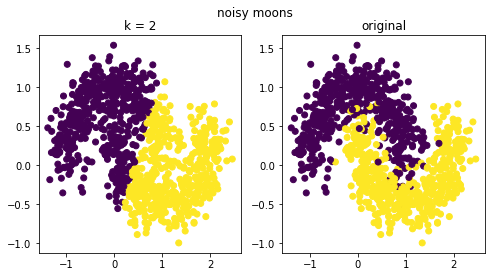

In [18]:
clusters, centers, costs = k_means(X2, 2, 1e-5)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X2.T, c = clusters)
plt.title(f'k = 2')
plt.subplot(122)
plt.title('original')
plt.scatter(*X2.T, c = y2)

plt.suptitle('noisy moons');

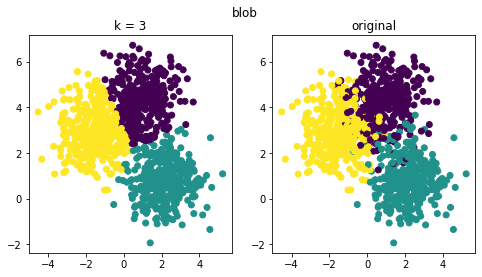

In [19]:
clusters, centers, costs = k_means(X3, 3, 1e-5)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X3.T, c = clusters)
plt.title(f'k = 3')
plt.subplot(122)
plt.title('original')
plt.scatter(*X3.T, c = y3)

plt.suptitle('blob');

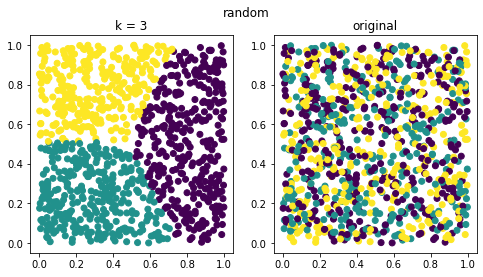

In [20]:
clusters, centers, costs = k_means(X4, 3, 1e-5)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X4.T, c = clusters)
plt.title(f'k = 3')
plt.subplot(122)
plt.title('original')
plt.scatter(*X4.T, c = y4)

plt.suptitle('random');

## 3

### DBScan

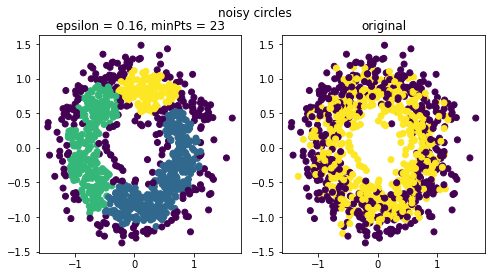

In [139]:
from sklearn.metrics import calinski_harabasz_score
minsamples = np.array([2, 5, 8, 10, 12, 14, 15, 16, 20, 23, 25, 30, 40])
epsilons = np.arange(0.01, 1, 0.03)
db_score = np.zeros((epsilons.shape[0], minsamples.shape[0]), dtype='float')
for j, minpts in enumerate(minsamples):
    for i, eps in enumerate(epsilons):
        db = DBSCAN(eps = eps, min_samples = minsamples[j]).fit(X1)
        try:
            db_score[i, j] = calinski_harabasz_score(X1, db.labels_)
        except:
            db_score[i, j] = 0
i, j = np.where(db_score == np.max(db_score, None))
db1 = DBSCAN(eps = epsilons[i[0]], min_samples = minsamples[j[0]]).fit(X1)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X1.T, c = db1.labels_)
plt.title(f'epsilon = {epsilons[i[0]]:.2f}, minPts = {minsamples[j[0]]}')
plt.subplot(122)
plt.title('original')
plt.scatter(*X1.T, c = y1)

plt.suptitle('noisy circles');

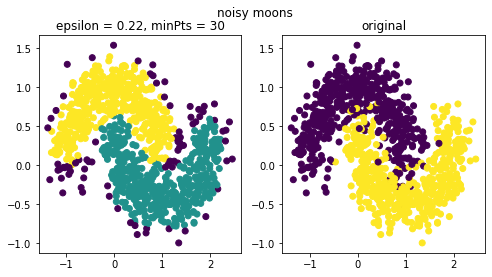

In [140]:
from sklearn.metrics import calinski_harabasz_score
minsamples = np.array([2, 5, 8, 10, 12, 14, 15, 16, 20, 23, 25, 30, 35, 40])
epsilons = np.arange(0.01, 1, 0.03)
db_score = np.zeros((epsilons.shape[0], minsamples.shape[0]), dtype='float')
for j, minpts in enumerate(minsamples):
    for i, eps in enumerate(epsilons):
        db = DBSCAN(eps = eps, min_samples = minsamples[j]).fit(X2)
        try:
            db_score[i, j] = calinski_harabasz_score(X2, db.labels_)
        except:
            db_score[i, j] = 0
i, j = np.where(db_score == np.max(db_score, None))
db2 = DBSCAN(eps = epsilons[i[0]], min_samples = minsamples[j[0]]).fit(X2)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X2.T, c = db2.labels_)
plt.title(f'epsilon = {epsilons[i[0]]:.2f}, minPts = {minsamples[j[0]]}')
plt.subplot(122)
plt.title('original')
plt.scatter(*X2.T, c = y2)

plt.suptitle('noisy moons');

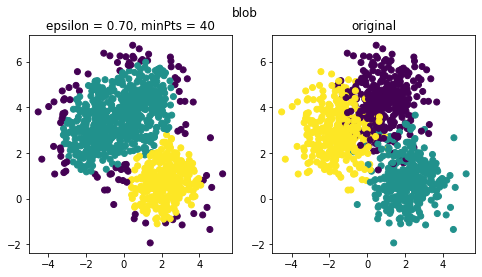

In [141]:
from sklearn.metrics import calinski_harabasz_score
minsamples = np.array([2, 5, 8, 10, 12, 14, 15, 16, 20, 23, 25, 30, 35, 40])
epsilons = np.arange(0.01, 1, 0.03)
db_score = np.zeros((epsilons.shape[0], minsamples.shape[0]), dtype='float')
for j, minpts in enumerate(minsamples):
    for i, eps in enumerate(epsilons):
        db = DBSCAN(eps = eps, min_samples = minsamples[j]).fit(X3)
        try:
            db_score[i, j] = calinski_harabasz_score(X3, db.labels_)
        except:
            db_score[i, j] = 0
i, j = np.where(db_score == np.max(db_score, None))
db3 = DBSCAN(eps = epsilons[i[0]], min_samples = minsamples[j[0]]).fit(X3)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X3.T, c = db3.labels_)
plt.title(f'epsilon = {epsilons[i[0]]:.2f}, minPts = {minsamples[j[0]]}')
plt.subplot(122)
plt.title('original')
plt.scatter(*X3.T, c = y3)

plt.suptitle('blob');

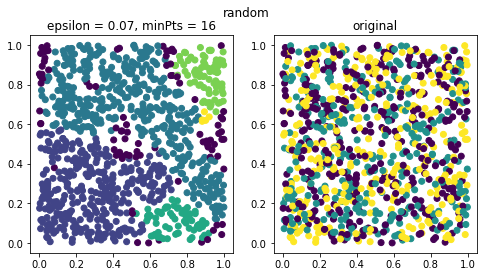

In [142]:
from sklearn.metrics import calinski_harabasz_score
minsamples = np.array([2, 5, 8, 10, 12, 14, 15, 16, 20, 23, 25, 30, 35, 40])
epsilons = np.arange(0.01, 1, 0.03)
db_score = np.zeros((epsilons.shape[0], minsamples.shape[0]), dtype='float')
for j, minpts in enumerate(minsamples):
    for i, eps in enumerate(epsilons):
        db = DBSCAN(eps = eps, min_samples = minsamples[j]).fit(X4)
        try:
            db_score[i, j] = calinski_harabasz_score(X4, db.labels_)
        except:
            db_score[i, j] = 0
i, j = np.where(db_score == np.max(db_score, None))
db4 = DBSCAN(eps = epsilons[i[0]], min_samples = minsamples[j[0]]).fit(X4)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X4.T, c = db4.labels_)
plt.title(f'epsilon = {epsilons[i[0]]:.2f}, minPts = {minsamples[j[0]]}')
plt.subplot(122)
plt.title('original')
plt.scatter(*X4.T, c = y4)

plt.suptitle('random');

## 4

### Agglomerative Clustering

In [143]:
from sklearn.cluster import AgglomerativeClustering

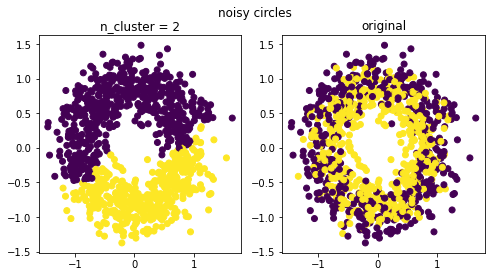

In [144]:
agg1 = AgglomerativeClustering(2, linkage='ward').fit(X1)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X1.T, c = agg1.labels_)
plt.title(f'n_cluster = 2')
plt.subplot(122)
plt.title('original')
plt.scatter(*X1.T, c = y1)

plt.suptitle('noisy circles');

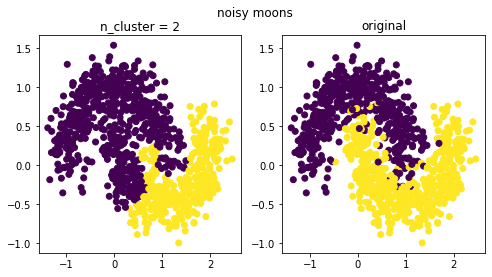

In [145]:
agg2 = AgglomerativeClustering(2, linkage='ward').fit(X2)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X2.T, c = agg2.labels_)
plt.title(f'n_cluster = 2')
plt.subplot(122)
plt.title('original')
plt.scatter(*X2.T, c = y2)

plt.suptitle('noisy moons');

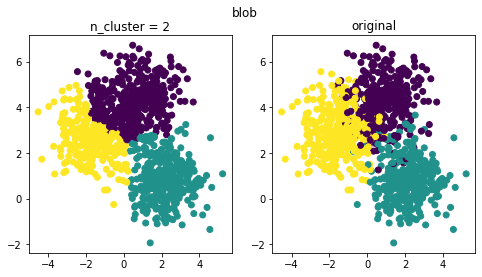

In [146]:
agg3 = AgglomerativeClustering(3, linkage='ward').fit(X3)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X3.T, c = agg3.labels_)
plt.title(f'n_cluster = 2')
plt.subplot(122)
plt.title('original')
plt.scatter(*X3.T, c = y3)

plt.suptitle('blob');

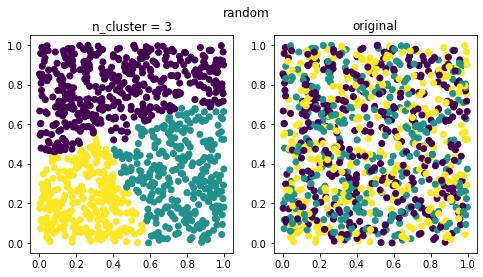

In [147]:
agg4 = AgglomerativeClustering(3, linkage='ward').fit(X4)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*X4.T, c = agg4.labels_)
plt.title(f'n_cluster = 3')
plt.subplot(122)
plt.title('original')
plt.scatter(*X4.T, c = y4)

plt.suptitle('random');

## 5

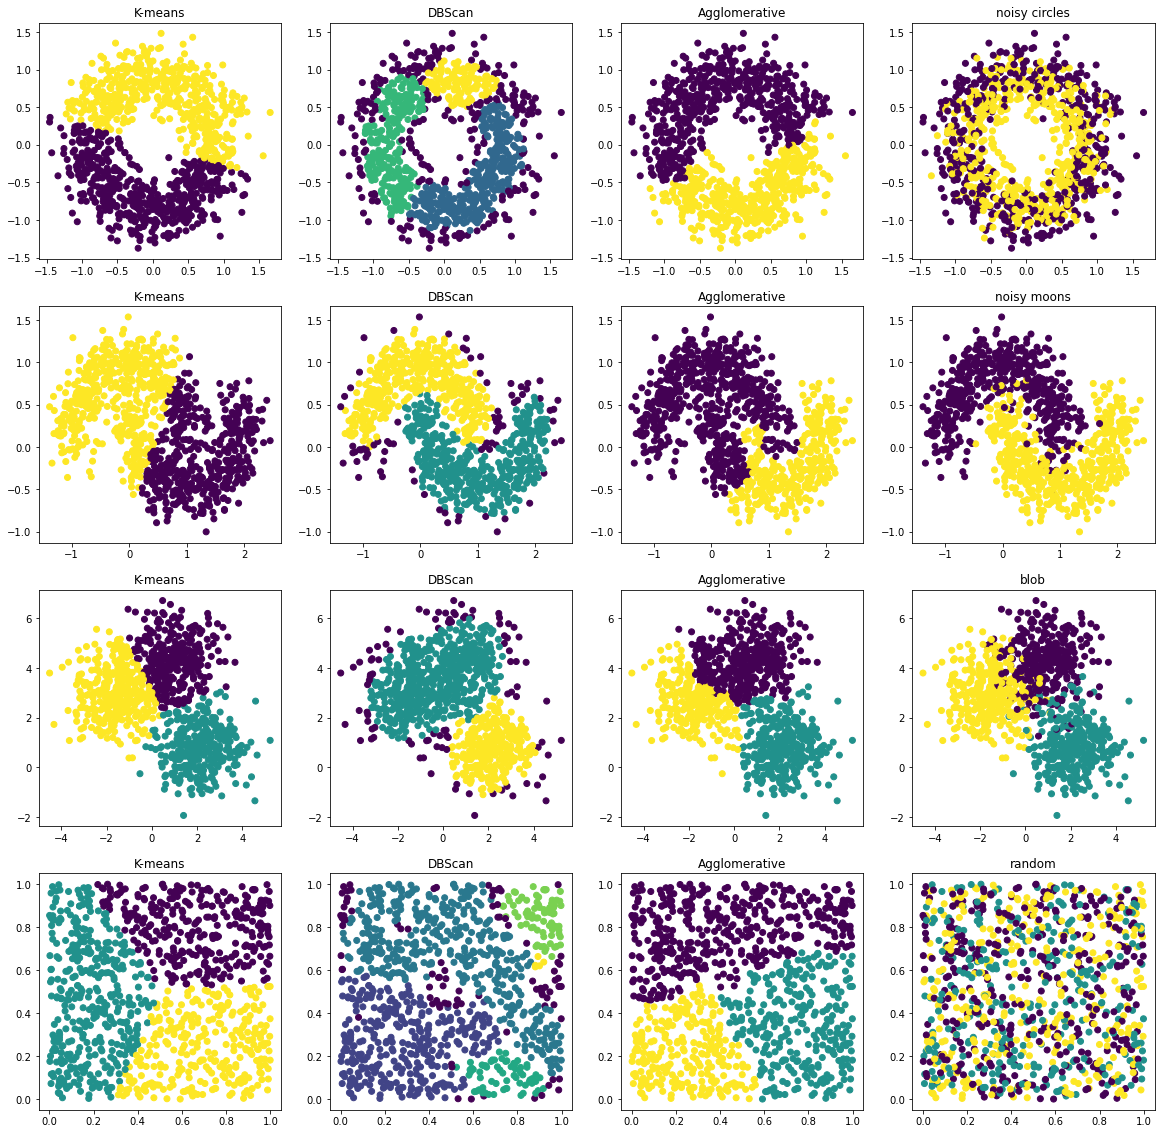

In [151]:
clusters1, centers, costs = k_means(X1, 2, 1e-5)
clusters2, centers, costs = k_means(X2, 2, 1e-5)
clusters3, centers, costs = k_means(X3, 3, 1e-5)
clusters4, centers, costs = k_means(X4, 3, 1e-5)

names = ['noisy circles', 'noisy moons', 'blob', 'random']

plt.figure(figsize=(20, 20))
for i in range(1, 5):
    cluster = eval(f"clusters{i}")
    db = eval(f"db{i}")
    agg = eval(f"agg{i}")
    x = eval(f"X{i}")
    y = eval(f"y{i}")
    j = 4 * (i - 1)
    plt.subplot(4,4, j + 1)
    plt.title("K-means")
    plt.scatter(*x.T, c = cluster)

    plt.subplot(4, 4, j + 2)
    plt.title("DBScan")
    plt.scatter(*x.T, c = db.labels_)

    plt.subplot(4, 4, j + 3)
    plt.title("Agglomerative")
    plt.scatter(*x.T, c = agg.labels_)

    plt.subplot(4, 4, j + 4)
    plt.title(names[i-1])
    plt.scatter(*x.T, c = y)

<div dir='rtl'>
به صورت کلی برای هندسه‌های دایره‌ای دی بی اسکن بهتر عمل میکند. در شکل بلاب که میتوان کلاستر ها را دایره دانست و فاصله بین آن ها خطی است(به طور کلی بر اساس فاصله جدا پذیر هستند) هر رو روش کا مینز و اگلومریتیو قابل قبول هستند. شکل رندم را نیز به هیچ صورتی نمیتوان به کلاستر های خوبی دسته بندی کرد.